Here are histograms of graph level features. Centralities (that are essentially node features) represent mean of *** centrality for the graph.

In [1]:
import dgl
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
from utils import *

In [2]:
pickle_name = 'nx_dataset.pickle'
with open(pickle_name, 'rb') as f:
    nx_train_set, nx_val_set, nx_test_set = pickle.load(f)


In [3]:
train_set = add_time_difference(nx_train_set)
val_set = add_time_difference(nx_val_set)
test_set = add_time_difference(nx_test_set)
print('time done')

train_set = add_domain(train_set)
val_set = add_domain(val_set)
test_set = add_domain(test_set)
print('domain done')

train_set = add_sna(train_set)
val_set = add_sna(val_set)
test_set = add_sna(test_set)
print('sna done')


time done
domain done
sna done


In [4]:
np.set_printoptions(precision=2)
def add_node_embedding(dataset):
    fvs = []
    labels = []
    for j in range(len(dataset)):
        no_time_flag = 0
        g = dataset[j][0]
        levels = np.zeros(3)
        snas = np.zeros((len(g.nodes), 5))
        time_diffs = []
        for i in range(len(g.nodes)):
            n = g.nodes[i]
            g.nodes[i]['h'] = torch.tensor([
                0.,0., 0.,  # one hot level encoding
                n['time_diff'], n['no_time'],
                *n['sna']
            ])
            snas[i] = n['sna']
            levels[g.nodes[i]['level']] += 1
            if n['no_time'] != 1:
                time_diffs.append(n['time_diff'])
            else: 
                no_time_flag += 1
        links = 0
        titles = 0
        domain = 0
        for e in g.edges:
            if g.edges[e]['link_type']=='link':
                links +=1
                
            if g.edges[e]['link_type']=='title':
                titles +=1
            if g.edges[e]['link_type']=='domain':
                domain += 0.5
                
        levels /= len(g.nodes)
        time_diff_mean = np.asarray(time_diffs).mean()
        time_diff_std = np.asarray(time_diffs).std()
        no_time_flag /= len(g.nodes)
        
        mean_sna = snas.mean(0)
        
        fv = np.array([*levels, time_diff_mean, time_diff_std, no_time_flag,  *mean_sna, len(g.nodes), len(g.edges), links/(links+titles), domain/len(g.nodes)])
        fvs.append(fv)
        labels.append(dataset[j][1])
    return np.asarray(fvs), np.asarray(labels)

train_fvs, train_labels = add_node_embedding(train_set)
val_fvs, val_labels = add_node_embedding(val_set)
test_fvs, test_labels = add_node_embedding(test_set)

In [5]:
fv = np.asarray([*train_fvs, *val_fvs, *test_fvs])
# print(fv.shape)
labels = np.asarray([*train_labels, *val_labels, *test_labels])
normal_fv = fv[labels==0]
prop_fv = fv[labels==1]
print(normal_fv.shape)
features = [
    '# level 0 / # nodes', 
    '# level 1 / # nodes', 
    '# level 2 / # nodes', 
    'mean time difference',
    'std time difference',
    'no time flag', 
    'in degree centrality', 
    'out degree centrality',
    'closeness centrality', 
    'eigenvector centrality', 
    'clustering coefficient', 
    '# nodes', 
    '# edges', 
    'links/(links+titles)',
    '# domain edges / 2 # nodes'
]

(128, 15)


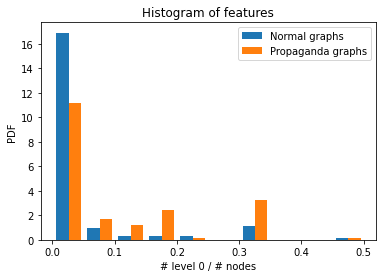

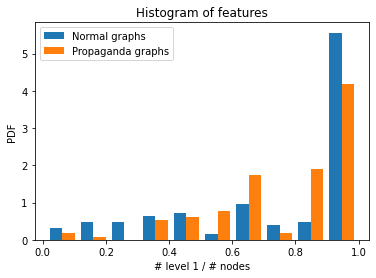

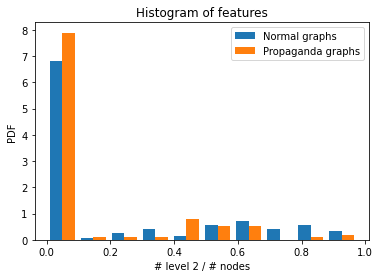

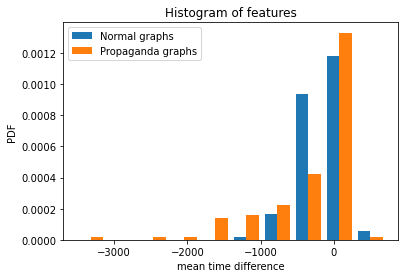

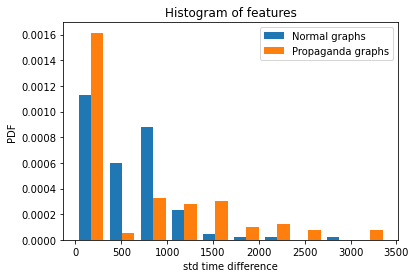

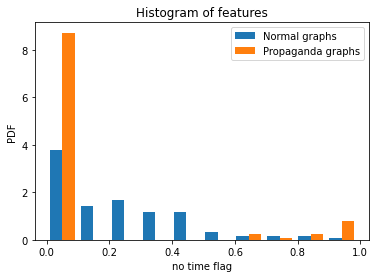

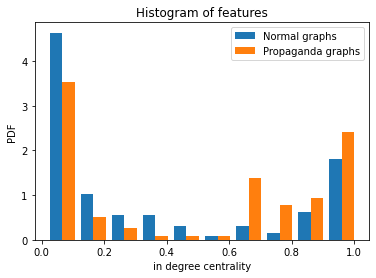

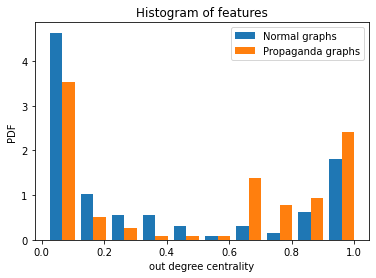

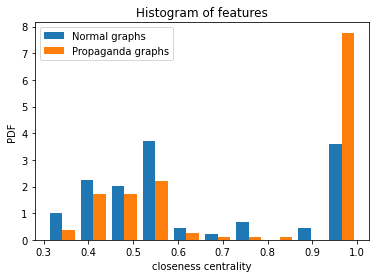

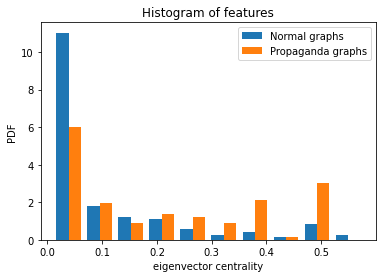

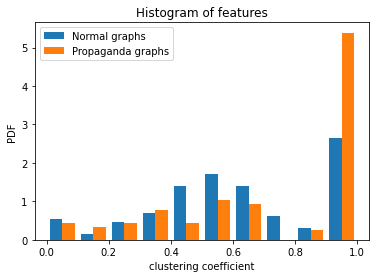

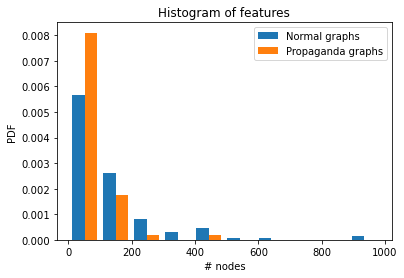

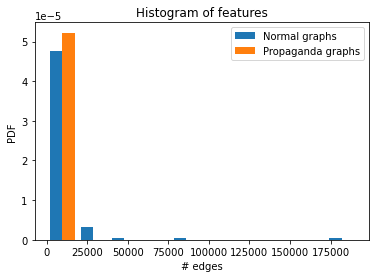

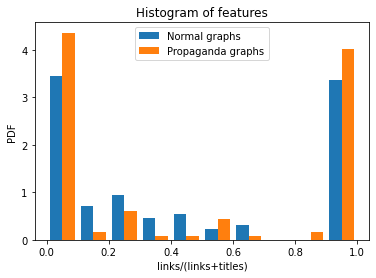

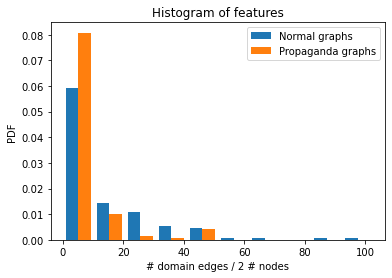

In [6]:
for feature_id in range(len(features)):
    plt.figure()
    plt.title('Histogram of features')
    plt.ylabel('PDF')
    plt.xlabel(features[feature_id])
#     plt.hist(, density=True,  label='Normal graphs', alpha=0.5)
    plt.hist([normal_fv[:, feature_id], prop_fv[:, feature_id]], density=True, label=['Normal graphs', 'Propaganda graphs']) 
#     plt.hist([train, val, test], density=True, label=['train', 'val', 'test'])

    plt.legend()
    plt.show()

(0, '# level 0 / # nodes')
(1, '# level 1 / # nodes')
(2, '# level 2 / # nodes')
(3, 'mean time difference')
(4, 'std time difference')
(5, 'no time flag')
(6, 'in degree centrality')
(7, 'out degree centrality')
(8, 'closeness centrality')
(9, 'eigenvector centrality')
(10, 'clustering coefficient')
(11, '# nodes')
(12, '# edges')
(13, 'links/(links+titles)')
(14, '# domain edges / 2 # nodes')
[ 1.26e-02 -1.50e-03 -1.11e-02  1.44e+01 -3.56e+01 -2.59e-03  1.77e-02  1.77e-02  1.65e-02  1.67e-02  6.13e-03 -6.20e+00 -2.65e+02  2.28e-02
 -5.40e-01]
[-1.50e-03  7.13e-02 -6.98e-02  1.75e+01 -5.20e+01  2.74e-03  3.55e-02  3.55e-02  2.97e-02  3.96e-03  2.06e-02 -1.82e+01 -1.06e+03  2.02e-02
 -1.43e-01]
[-1.11e-02 -6.98e-02  8.10e-02 -3.19e+01  8.77e+01 -1.47e-04 -5.31e-02 -5.31e-02 -4.62e-02 -2.07e-02 -2.67e-02  2.44e+01  1.32e+03 -4.30e-02
  6.83e-01]
[ 1.44e+01  1.75e+01 -3.19e+01  2.37e+05 -2.47e+05  1.82e+01  9.13e+01  9.13e+01  5.67e+01  2.68e+01  7.07e+01 -5.36e+03  2.72e+05  9.49e+01
  

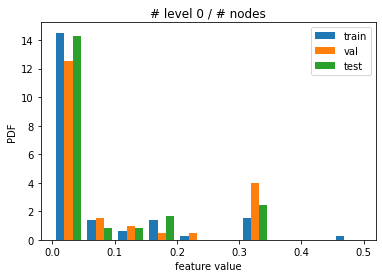

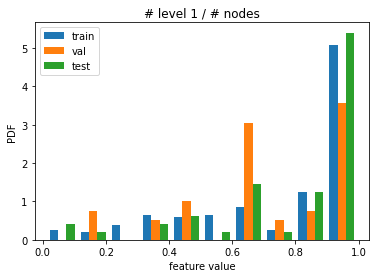

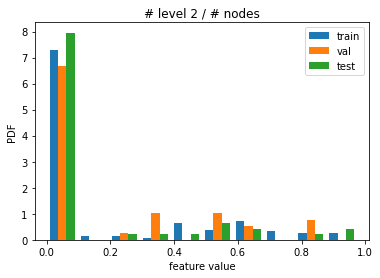

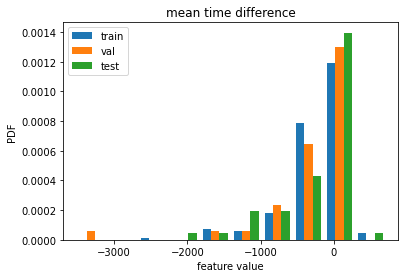

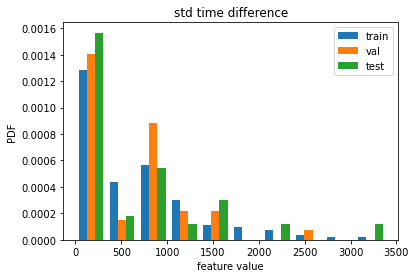

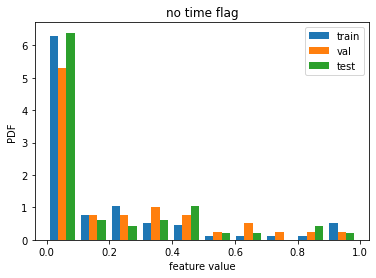

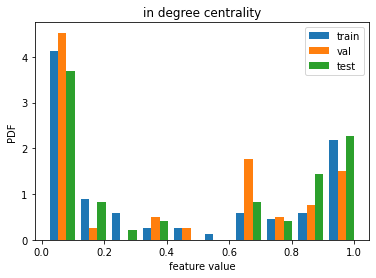

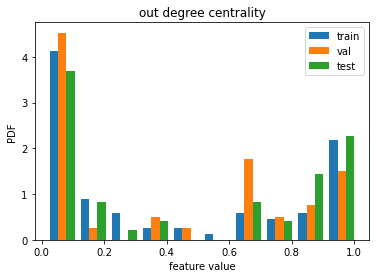

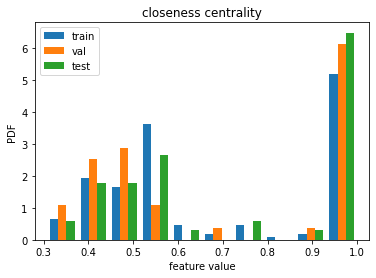

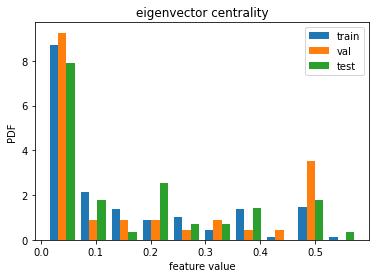

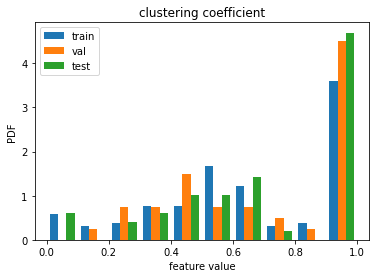

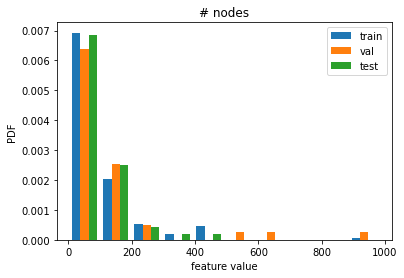

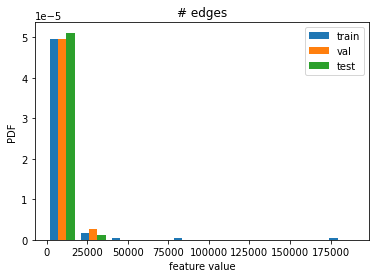

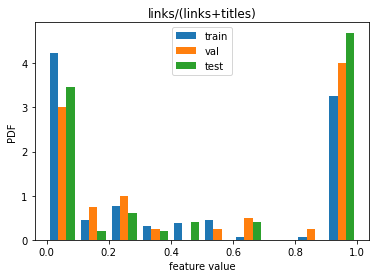

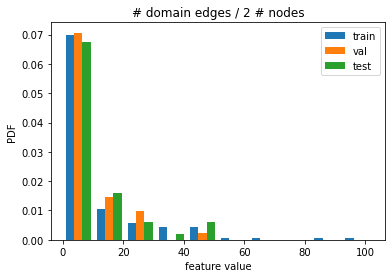

In [8]:

# [*levels, time_diff_mean, *mean_sna, len(g.nodes), len(g.edges), links/(links+titles), domain/len(g.nodes)])

for feature_id in range(train_fvs.shape[1]):
    plt.figure()
    plt.title(features[feature_id])
    train = train_fvs[:, feature_id]
    val = val_fvs[:, feature_id]
    test = test_fvs[:, feature_id]
    plt.hist([train, val, test], density=True, label=['train', 'val', 'test'])
    plt.xlabel('feature value')
    plt.ylabel('PDF')
    plt.legend()
    plt.show()
    

In [9]:
splits=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

for feature_id in range(train_fvs.shape[1]):
    trains, vals = [], []
    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(train_set)), train_labels)):
        trains.append(train_fvs[train_idx])
        vals.append(train_fvs[val_idx])
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15, 5))
    trains_id = [trains[i][:, feature_id] for i in range(len(trains))]
    vals_id = [vals[i][:, feature_id] for i in range(len(vals))]
    fig.suptitle(f'{features[feature_id]} per fold')
    ax1.set_title('train split')
    ax2.set_title('val split')
    ax1.hist(trains_id, density=True,)
    ax2.hist(vals_id, density=True,)
    ax1.set_xlabel('feature value')
    ax1.set_ylabel('PDF')
    ax2.set_xlabel('feature value')
    ax2.set_ylabel('PDF')
    plt.show()

NameError: name 'StratifiedKFold' is not defined